
# Linear Regression from Scratch

This notebook implements **Linear Regression** using **Batch Gradient Descent**, **Stochastic Gradient Descent**, **Newton-Raphson**  and **Normal Equation** methods, 
as taught in **Stanford's CS229: Machine Learning (Autumn 2018, Lecture 3)** by Andrew Ng.

It includes:
- Feature normalization using Z-score
- Cost function visualization
- Optimization using gradient descent
- Closed-form solution using the normal equation
- 3D plots and performance comparison

> 📘 This is part of a broader `ml-from-scratch` project implementing ML algorithms using only NumPy and pandas for educational purposes.


In [1]:
import pickle
import numpy as np
from typing import Union,List
import pandas as pd
from numpy import ndarray
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class LinearRegression:
    def __init__(self):
        self.x_mean: ndarray = None
        self.x_std: ndarray = None
        self.y_mean: ndarray = None
        self.y_std: ndarray = None
        self.Theta: ndarray = None  # From Normal Equation
        self.theta: ndarray = None  # From Batch GD
        self.thetaSGD: ndarray = None  # From SGD
        self.thetaNR: ndarray = None
        self.x_norm: ndarray = None
        self.y_norm: ndarray = None
        self.is_norm: bool = False

    def normalize(self, x_train: ndarray, y_train: ndarray, add_bias=True):
        self.x_mean = x_train.mean(axis=0)
        self.x_std = x_train.std(axis=0)
        self.y_mean = y_train.mean(axis=0)
        self.y_std = y_train.std(axis=0)

        self.x_std[self.x_std == 0] = 1
        self.y_std[self.y_std == 0] = 1

        self.x_norm = (x_train - self.x_mean) / self.x_std
        self.y_norm = (y_train - self.y_mean) / self.y_std

        if add_bias:
            x_0 = np.ones((self.x_norm.shape[0], 1))
            self.x_norm = np.hstack((x_0, self.x_norm))

        self.is_norm = True
        return self.x_norm, self.y_norm, *self.x_norm.shape, self.x_mean, self.x_std, self.y_mean, self.y_std

    @staticmethod
    def h(x: ndarray, theta: ndarray) -> ndarray:
        return np.dot(x, theta)

    @staticmethod
    def J(x: ndarray, y: ndarray, theta: ndarray) -> float:
        m = x.shape[0]
        error = LinearRegression.h(x, theta) - y
        return (1 / (2 * m)) * np.sum(np.square(error))

    def fit(self, x_train: ndarray, y_train: ndarray, add_bias: bool = True) -> ndarray:
        if not self.is_norm:
            self.normalize(x_train, y_train, add_bias)
        XtX_inv = np.linalg.pinv(self.x_norm.T @ self.x_norm)
        Xty = self.x_norm.T @ self.y_norm
        theta = XtX_inv @ Xty
        loss = self.J(self.x_norm, self.y_norm, theta)
        print(f"[Normal Eq] Loss = {loss}")
        self.Theta = theta
        return theta

    def trainSGD(self, x_train: ndarray, y_train: ndarray, alpha: float, theta: ndarray = None, epoch: int = 100, add_bias: bool = True) -> ndarray:
        if not self.is_norm:
            self.normalize(x_train, y_train, add_bias)
        if theta is None:
            theta = np.zeros((self.x_norm.shape[1], 1))
        m = self.x_norm.shape[0]
        losses = []

        for _ in range(epoch):
            for i in range(m):
                xi = self.x_norm[i].reshape(1, -1)  # (1, n)
                yi = self.y_norm[i]
                error = LinearRegression.h(xi, theta) - yi
                grad = xi.T * error
                theta -= alpha * grad
            losses.append(self.J(self.x_norm, self.y_norm, theta))

        self.thetaSGD = theta
        print(f"[SGD] Final Loss = {self.J(self.x_norm, self.y_norm, theta)}")

        plt.plot(range(1, epoch + 1), losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("SGD Loss Curve")
        plt.show()

        return theta

    def train(self, x_train: ndarray, y_train: ndarray, alpha: float, theta: ndarray = None, epoch: int = 100, add_bias: bool = True) -> ndarray:
        if not self.is_norm:
            self.normalize(x_train, y_train, add_bias)
        if theta is None:
            theta = np.zeros((self.x_norm.shape[1], 1))
        m = self.x_norm.shape[0]
        losses = []

        for _ in range(epoch):
            error = LinearRegression.h(self.x_norm, theta) - self.y_norm
            grad = (1 / m) * self.x_norm.T @ error
            theta -= alpha * grad
            losses.append(self.J(self.x_norm, self.y_norm, theta))

        self.theta = theta
        print(f"[Batch GD] Final Loss = {self.J(self.x_norm, self.y_norm, theta)}")

        plt.plot(range(1, epoch + 1), losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("Batch GD Loss Curve")
        plt.show()

        return theta
    
    def trainNR(self, x_train: ndarray, y_train: ndarray, theta: ndarray = None, epoch: int = 100, add_bias: bool = True) -> ndarray:
        if not self.is_norm:
            self.normalize(x_train, y_train, add_bias)
        if theta is None:
            theta=np.zeros((self.x_norm.shape[1], 1))
        m = self.x_norm.shape[0]
        losses = []
        hasian = (1 / m) * (self.x_norm.T @ self.x_norm)
        H_inv = np.linalg.pinv(hasian)
        for _ in range(epoch):
            grad = (1 / m) * self.x_norm.T @ (self.h(self.x_norm, theta) - self.y_norm)
            theta -= H_inv @ grad
            losses.append(self.J(self.x_norm,self.y_norm,theta))

        self.thetaNR = theta
        print(f"[Newton-Raphson] Final Loss = {self.J(self.x_norm, self.y_norm, theta)}")

        plt.plot(range(1, epoch + 1), losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.title("Newton-Raphson Loss Curve")
        plt.show()

        return theta

    def save(self, filepath) -> None:
        data = {
            "x_mean": self.x_mean,
            "x_std": self.x_std,
            "y_mean": self.y_mean,
            "y_std": self.y_std,
            "theta": self.theta,
            "Theta": self.Theta,
            "thetaSGD": self.thetaSGD,
            "thetaNR": self.thetaNR
        }
        with open(filepath, 'wb') as f:
            pickle.dump(data, f)

    class Loader:
        def __init__(self, path: str):
            with open(path, 'rb') as f:
                data = pickle.load(f)

            self.x_mean = data.get("x_mean")
            self.x_std = data.get("x_std")
            self.y_mean = data.get("y_mean")
            self.y_std = data.get("y_std")
            self.theta = data.get("theta")
            self.Theta = data.get("Theta")
            self.thetaSGD = data.get("thetaSGD")
            self.thetaNR = data.get("thetaNR")

        def predict(
            self,
            X_input: Union[List[float], List[List[float]]],
            use_theta: bool = False,
            use_Theta: bool = False,
            use_thetaSGD: bool = False,
            use_thetaNR: bool = False,
            add_bias: bool = False
        ) -> ndarray:
            X_input = np.array(X_input, dtype=float)
            if X_input.ndim == 1:
                X_input = X_input.reshape(1, -1)

            X_norm = (X_input - self.x_mean) / self.x_std

            if add_bias:
                if not np.allclose(X_norm[:, 0], 1.0):
                    X_norm = np.hstack((np.ones((X_norm.shape[0], 1)), X_norm))

            theta_used = None
            if use_theta and self.theta is not None:
                theta_used = self.theta
                print("Using `theta` (Batch GD)")
            elif use_Theta and self.Theta is not None:
                theta_used = self.Theta
                print("Using `Theta` (Normal Eq)")
            elif use_thetaSGD and self.thetaSGD is not None:
                theta_used = self.thetaSGD
                print("Using `thetaSGD` (SGD)")
            elif use_thetaNR and self.thetaNR is not None:
                theta_used = self.thetaNR
                print("Using `thetaNR` (NRM)")
            elif self.theta is not None:
                theta_used = self.theta
                print("Defaulting to `theta` (Batch GD)")
            else:
                raise ValueError("No valid theta found for prediction.")

            y_pred_norm = LinearRegression.h(X_norm, theta_used)
            return y_pred_norm * self.y_std + self.y_mean


In [3]:
data = pd.read_csv("./data/Data.txt", header=None,
                   names=["Size_sqft", "Bedrooms", "Price_USD"])
print(data.isnull().sum())
data.head()

Size_sqft    0
Bedrooms     0
Price_USD    0
dtype: int64


,Size_sqft,Bedrooms,Price_USD
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [4]:
x_train = data[["Size_sqft", "Bedrooms"]].values
y_train = data[["Price_USD"]].values

[Newton-Raphson] Final Loss = 0.13352749098554287


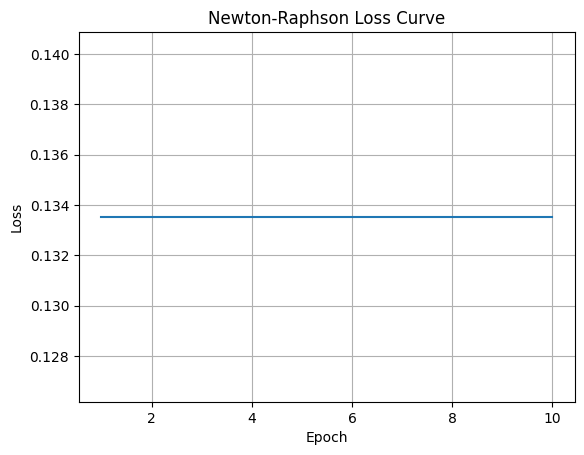

array([[-8.54621654e-17],
       [ 8.84765988e-01],
       [-5.31788197e-02]])

In [5]:
model = LinearRegression()
model.trainNR(x_train,y_train,epoch=10)